In [54]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns; sns.set()
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")
def get_visit_list(s):
    data={}
    data['visit_list'] = s['用户ID'].tolist()
    return pd.Series(data)
def get_order_people(s):
    data={}
    data['会员人数']=s['会员ID'].tolist()
    return pd.Series(data)

In [5]:
sql={'query': {'bool': {'must': [{'range': {'paytime': {'gte': '2019-05-30', 'lte': '2019-06-14', 'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, {'terms': {'group_city': ['阳江市']}}, {'terms': {'order_type': ['vip_scan', 'deal']}}, {'terms': {'order_status': ['done', 'fulfilled', 'confirmed']}}, {'range': {'card_discount': {'gt': 0}}}]}}, 'aggs': {'my_buckets': {'composite': {'size': 9999999, 'sources': [{'日期': {'date_histogram': {'field': 'paytime', 'interval': '1d', 'time_zone': '+00:00'}}}]}, 'aggregations': {}}}}

In [6]:
pprint(sql)

{'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                              'interval': '1d',
                                                                              'time_zone': '+00:00'}}}]}}},
 'query': {'bool': {'must': [{'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-30',
                                                    'lte': '2019-06-14',
                                                    'time_zone': '+00:00'}}},
                             {'terms': {'group_city': ['阳江市']}},
                             {'terms': {'order_type': ['vip_scan', 'deal']}},
                             {'terms': {'order_status': ['done',
                                                         'fulfilled',
                   

In [66]:
def larger_than_two(date):
    dsl ={'aggs': {'my_buckets': {'aggregations': {},
                             'composite': {'size': 9999999,
                                           'sources': [{'会员ID':{'terms':{'field':'user_id'}}},
                                                       #{'日期': {'date_histogram': {'field': 'paytime',
                                                       #                           'interval': '1d',
                                                       #                           'time_zone': '+00:00'}}}
                                                      ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                        'gte': date,
                                                        'lte': date,
                                                        'time_zone': '+00:00'}}},
                                 {'terms': {'group_city': ['阳江市']}},
                                 {'terms': {'order_type': ['vip_scan', 'deal']}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}},
                                 {'range': {'card_discount': {'gt': 0}}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))

    df_ls = df.groupby('doc_count').apply(get_order_people).reset_index()
    
    sum_1 = 0
    for i in range(len(df_ls)):
        sum_1+=len(df_ls.iloc[i]['会员人数'])
    
    return 1-len(df_ls.iloc[0]['会员人数'])/sum_1

In [67]:
date='2019-05-30'
larger_than_two(date)

0.10446137105549513

In [68]:
date = '2019-04-29'
date_index_list,percentage=[],[]
for i in range(30):
    date_index=str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10]
    date_index_list.append(date_index)
    percentage.append(larger_than_two(date_index))
val = {'date_index':date_index_list,'百分比':percentage}
lw_list=pd.DataFrame(val)

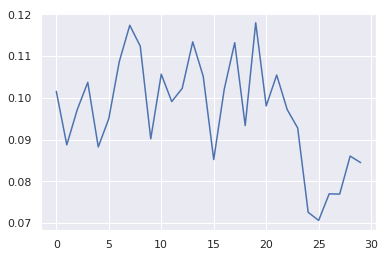

In [69]:
plt.plot(lw_list['百分比'])

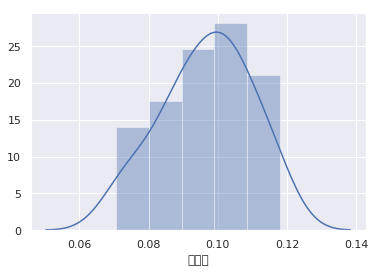

In [70]:
sns.distplot(lw_list['百分比'])

In [129]:
def shop_cate_other(date):
    dsl ={'aggs': {'my_buckets': {'aggregations': {},
                                 'composite': {'size': 9999999,
                                               'sources': [{'会员ID':{'terms':{'field':'user_id'}}},
                                                           {'group_category_name': {'terms': {'field': 'group_category_name'}}}
                                                           #{'日期': {'date_histogram': {'field': 'paytime',
                                                           #                           'interval': '1d',
                                                           #                           'time_zone': '+00:00'}}}
                                                          ]}}},
         'query': {'bool': {'must': [{'range': {'paytime': {'format': 'yyyy-MM-dd',
                                                            'gte': date,
                                                            'lte': date,
                                                            'time_zone': '+00:00'}}},
                                     {'terms': {'group_city': ['阳江市']}},
                                     {'terms': {'order_type': ['vip_scan', 'deal']}},
                                     {'terms': {'order_status': ['done',
                                                                 'fulfilled',
                                                                 'confirmed']}},
                                     {'range': {'card_discount': {'gt': 0}}}]
                           }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    df_new=df[df['doc_count']>1]
    df_new_1=df_new[df_new['group_category_name']!='网咖']
    df_new_2=df_new_1[df_new_1['group_category_name']!='便利店']
    df_new_3=df_new_2[df_new_2['group_category_name']!='早餐档']
    
    return df_new_3['会员ID'].tolist()

In [130]:
date = '2019-04-29'
date_index_list,user_id_haha=[],[]
for i in range(30):
    date_index=str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10]
    date_index_list.append(date_index)
    user_id_haha.append(shop_cate_other(date_index))
val = {'date_index':date_index_list,'pianbutie':user_id_haha}
bt_list=pd.DataFrame(val)

In [131]:
bt_list

,date_index,pianbutie
0,2019-04-29,"[633494, 649942, 680187, 680247]"
1,2019-04-30,"[633937, 670428]"
2,2019-05-01,[695460]
3,2019-05-02,"[689185, 698384]"
4,2019-05-03,[701429]
5,2019-05-04,"[707085, 709137]"
6,2019-05-05,"[615791, 633494, 680187, 702634, 709233, 71423..."
7,2019-05-06,"[633494, 655590, 660922, 688703, 716742]"
8,2019-05-07,"[632679, 720347]"
9,2019-05-08,"[629725, 672094, 729081]"


In [125]:
shop_cate_other('2019-05-21')

,doc_count,group_category_name,会员ID
25,2,火锅,410520
82,2,火锅,457260
396,2,面包甜点,569223
968,2,小吃,720347
1138,2,下午茶,774408
1200,2,下午茶,790337
1201,2,下午茶,790343
1681,2,下午茶,795792
1683,2,下午茶,795806
